<a href="https://colab.research.google.com/github/anirudhagar13/sentiment_analysis/blob/main/CSCI5525_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data \& Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import sys
import re, nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
!pip install stemming

import spacy

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer

import collections
from stemming.porter2 import stem as Portstemmer

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import ensemble, linear_model, neighbors, naive_bayes, svm

from scipy import sparse

from xgboost import XGBClassifier
from gensim.models.wrappers import FastText
# Nltk corpora to be loaded 
nltk.download('stopwords')
nltk.download('wordnet')

## Global constants
nlp_spacy = spacy.load('en_core_web_sm')
nltk_lem = WordNetLemmatizer()
alphanum_tokenizer = RegexpTokenizer(r'\w+')
nltk_stop_words = list(stopwords.words('english'))

nlp_spacy = spacy.load('en_core_web_sm')
nltk_lem = WordNetLemmatizer()

In [3]:
import tensorflow_hub as hub
import tensorflow as tf

from sklearn.manifold import TSNE

In [4]:
# This dataset Reference: https://www.kaggle.com/columbine/imdb-dataset-sentiment-analysis-in-csv-format?select=Valid.csv
# Another dataset Reference: https://www.kaggle.com/jcblaise/imdb-sentiments
imdb_train = pd.read_csv('drive/Shareddrives/CSCI 5525/IMDB_data/Train.csv')
imdb_valid = pd.read_csv('drive/Shareddrives/CSCI 5525/IMDB_data/Valid.csv')
imdb_test = pd.read_csv('drive/Shareddrives/CSCI 5525/IMDB_data/Test.csv')

# Combining Train and validation data (As would be using K-cross fold)
imdb_train = imdb_train.append(imdb_valid, ignore_index=True)

## Basic EDA
- Taking a sneak peek of the data
- Cannot do much EDA as data is text

In [5]:
imdb_train.shape
imdb_valid.shape

(5000, 2)

In [6]:
imdb_train.head()

text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1

In [7]:
# Classes balanced
imdb_train.label.value_counts()

0    22505
1    22495
Name: label, dtype: int64

## Data Cleansing
- Can try various cleansing by:
  - Changing function parameters
  - Adding more functionalities (in terms of text cleansing)

In [8]:
def preprocessing(text, lowercase=True, stopwords=True, alpha_num=False, 
                  stemming=False, lemmatization=True):
    # Clear trailing spaces
    text = text.strip()
 
    # removing extra space
    text = re.sub(' +', ' ', text)

    # Reduce to lower case
    if lowercase:
        text = text.lower()

    # Ignore certain words
    # Removing non-alphanums  
    words_list = list()
    if alpha_num:
        words_list = alphanum_tokenizer.tokenize(text)
    else:
        # Simple tokenization
        words_list = word_tokenize(text)

    # Removing single length words, covering shortcoming of tokenization
    words_list = [x for x in words_list if len(x) > 2]

    # Removing stopwords
    if stopwords:
        words_list = [x for x in words_list if x not in nltk_stop_words]

    # Stemming
    if stemming:
        words_list = [Portstemmer(x) for x in words_list]

    # Lemmatization
    if lemmatization:
        words_list = [nltk_lem.lemmatize(x, pos = 'v') for x in words_list]

    # Joining words into sentence
    cleaned_text = ' '.join(words_list)

    return cleaned_text

## Vectorization
- A very crucial component in NLP pipeline is to find the right embedding
- To try: 
  - Can implement **word2vec**, **fasttext** and **GLove**
  - Could even explore specialised pretrained embedding models

In [9]:
def encode(sentences, labels, embedder):
    X = embedder(sentences) # Features, AKA embeddings
    y = (labels == 'y').astype(int) # Labels
    return X, y

EMBED_URL = "https://tfhub.dev/google/nnlm-en-dim50/2"  # The embedding model.
print("Getting embedding model...", end='')
embedder = hub.KerasLayer(EMBED_URL, dtype=tf.string, trainable=False) # The Layer, which does the transformation.
print("Done")

Getting embedding model...Done


In [10]:
count_vec_ner, count_vec_lemma, count_vec_tag = None, None, None

# Uses spacy to create a stacked vector representation
def spacy_vectorizer(data, n_dims=100):
    global count_vec_ner, count_vec_lemma, count_vec_tag
    all_ner, all_lemma, all_tag = list(), list(), list()
  
    for text in data:
        doc_inst = nlp_spacy(text)
        sent_ner, sent_lemma, sent_tag = list(), list(), list()

        for token in doc_inst:
            sent_lemma.append(token.lemma_)
            sent_tag.append(token.tag_)

        for ent in doc_inst.ents:
            sent_ner.append(ent.label_)

        # Collating for a sentence
        all_ner.append(" ".join(sent_ner))
        all_lemma.append(" ".join(sent_lemma))
        all_tag.append(" ".join(sent_tag))

    # Converting the attributes obtained above into vectors using CountVectorizer
    # No max vector dimensionality enforced
    if count_vec_ner is None:
        print ('Training Spacy NER Vectorizer')
        count_vec_ner = CountVectorizer(ngram_range=(1, 2), max_features=n_dims)
        count_vec_ner.fit(all_ner)
        
    if count_vec_lemma is None:
        print ('Training Spacy Lemma Vectorizer')
        count_vec_lemma = CountVectorizer(ngram_range=(1, 2), max_features=n_dims)
        count_vec_lemma.fit(all_lemma)
        
    if count_vec_tag is None:
        print ('Training Spacy Tag Vectorizer')
        count_vec_tag = CountVectorizer(ngram_range=(1, 2), max_features=n_dims)
        count_vec_tag.fit(all_tag)
        
    ner_vectors = count_vec_ner.transform(all_ner)
    lemma_vectors = count_vec_lemma.transform(all_lemma)
    tag_vectors = count_vec_tag.transform(all_tag)

    # Stacking and converting into non-sparse format
    return hstack([ner_vectors, lemma_vectors, tag_vectors]).tocsr()

In [11]:
# Converts questions to vectors (through variety of techniques)
import codecs
def vectorizer(train_data, test_data, n_dims=100, model='tf-idf'):
    train_vectors, test_vectors, vectorizer = list(), list(), object

    ## POS-tagging
    # if 'pos' in model.lower():


    ## TF-IDF
    if model.lower() == 'tf-idf':
        tfidf_vec = TfidfVectorizer(max_features=n_dims, ngram_range=(1,2))
        train_vectors = tfidf_vec.fit_transform(train_data)
        test_vectors = tfidf_vec.transform(test_data)
        vectorizer = tfidf_vec
        
    ## Count Vectors
    elif model.lower() == 'cv':
        cv_vec = CountVectorizer(max_features=n_dims, ngram_range=(1,2))
        train_vectors = cv_vec.fit_transform(train_data)
        test_vectors = cv_vec.transform(test_data)
        vectorizer = cv_vec
    
    ## GloVe 
    ## (Tried 840B.300d file - Bad results [Not included due to large file dependency])
    
    ## Word2Vec
    # elif model.lower() == 'word2vec':
    #     # Train word2vec on train vectors
    #     train_vectors = wordvec_vectorizer(train_data, n_dims)
    #     test_vectors = wordvec_vectorizer(test_data, n_dims)

    ## Keras Google Word2Vec
    elif model.lower() == 'keras':
      EMBED_URL = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2" 
      keras_vectorizer = hub.KerasLayer(EMBED_URL, dtype=tf.string, trainable=False)
      train_vectors = keras_vectorizer(train_data).numpy()
      test_vectors = keras_vectorizer(test_data).numpy()

    ## Spacy
    elif model.lower() == 'spacy':
        train_vectors = spacy_vectorizer(train_data, n_dims)
        test_vectors = spacy_vectorizer(test_data, n_dims)
        
    else:
        raise Exception('Vectorizer model not defined.')
    
    return train_vectors, test_vectors, vectorizer

## Preprocessing

In [12]:
# Text preprocessing (takes a while as happens sentence wise)
imdb_train['P_text'] = imdb_train['text'].apply(preprocessing)
imdb_test['P_text'] = imdb_test['text'].apply(preprocessing)

In [13]:
imdb_train[['text','P_text']].head()

text                                             P_text
0  I grew up (b. 1965) watching and loving the Th...  grow 1965 watch love thunderbirds mat school w...
1  When I put this movie in my DVD player, and sa...  put movie dvd player sit coke chip expectation...
2  Why do people who do not know what a particula...  people know particular time past like feel nee...
3  Even though I have great interest in Biblical ...  even though great interest biblical movies bor...
4  Im a die hard Dads Army fan and nothing will e...  die hard dads army fan nothing ever change get...

In [14]:
# Vectorization (In sparse matrix form)
X_train_kr, X_test_kr, vectorizer_kr = vectorizer(imdb_train['text'], imdb_test['text'], model='keras', n_dims=300)
X_train_tf, X_test_tf, vectorizer_tf = vectorizer(imdb_train['P_text'], imdb_test['P_text'], model='tf-idf', n_dims=300)
X_train_cv, X_test_cv, vectorizer_cv = vectorizer(imdb_train['P_text'], imdb_test['P_text'], model='cv', n_dims=300)

In [15]:
# storing labels
y_train, y_test = imdb_train['label'], imdb_test['label']

## Training and Validation
- Figure out the right Hypothesis space (among various ML Models)
- Then focus on tuning best performing models (using gridsearchCV)
- **Note:**  Models taking too much time for 5-cross validation on entire dataset

In [16]:
# Various types of ML models (linear, non-linear, ensemble, bayes)
MLA = [
    # Ensemble Methods
    ensemble.RandomForestClassifier(),
    
    # Logistic Regression
    linear_model.LogisticRegression(),
    
    # GLM
    # linear_model.SGDClassifier(),
    svm.SVC(kernel='linear'),
    
    # Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    # Naive Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.MultinomialNB(),
    naive_bayes.GaussianNB(),
    
    # SVM (Non-linear)
    svm.SVC(kernel='rbf'),
    svm.SVC(kernel='poly'),
    
    # xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
    ]

In [17]:
calc_parameters = {'accuracy': make_scorer(accuracy_score),
                   'precision': make_scorer(precision_score),
                   'recall': make_scorer(recall_score),
                   'f1': make_scorer(f1_score)}

In [18]:
# creating table to compare Machine Learning Algorithms (MLA) metrics
def comp_ml_alg(X, y, cv=3):
    MLA_columns = ['MLA Name', 'MLA Time']
    MLA_compare = pd.DataFrame()

    #index through MLA and save performance to table
    row_index = 0
    for alg in MLA:

        #set name and parameters
        MLA_name = alg.__class__.__name__
        
        # Specific renaming only for SVC
        if MLA_name == 'SVC':
          params = alg.get_params()
          if params['kernel'] == 'rbf':
            MLA_name = 'RBF_SVC'
          elif params['kernel'] == 'poly':
            MLA_name = 'POLY_SVC'
          else:
            MLA_name = 'Linear_SVC'

        MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
        # MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

        # Running cross-validation (Internal stratified folds created)
        cv_results = cross_validate(alg, X, y, cv=cv, return_train_score=True, 
                                    scoring=calc_parameters)

        # print(len(cv_results))
        # sys.exit()

        MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
        # MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_accuracy'].mean()
        # MLA_compare.loc[row_index, 'MLA Valid Accuracy Mean'] = cv_results['test_accuracy'].mean()   
        MLA_compare.loc[row_index, 'MLA Valid Precision Mean'] = cv_results['test_precision'].mean()
        MLA_compare.loc[row_index, 'MLA Valid Recall Mean'] = cv_results['test_recall'].mean()
        MLA_compare.loc[row_index, 'MLA Valid F1 Mean'] = cv_results['test_f1'].mean()

        row_index+=1

    MLA_compare.sort_values(by = ['MLA Valid F1 Mean'], ascending = False, inplace = True)
    return MLA_compare

In [19]:
# Drawing a sample to speed up model validation
N = 10000
sample = np.random.choice(np.arange(N), size=N, replace=True)

# Analyzing for coarse labels
mla_coarse_results_kr = comp_ml_alg(X_train_kr[sample], y_train[sample])
mla_coarse_results_tf = comp_ml_alg(X_train_tf[sample], y_train[sample])
mla_coarse_results_cv = comp_ml_alg(X_train_cv[sample], y_train[sample])

#### **Model Performance plots**

In [20]:
# Model comparison for Keras embedding
mla_coarse_results_kr

MLA Name  MLA Time  ...  MLA Valid Recall Mean  MLA Valid F1 Mean
0  RandomForestClassifier  6.109500  ...               0.876450           0.879715
7                 RBF_SVC  5.822511  ...               0.831999           0.837041
8                POLY_SVC  5.443012  ...               0.835405           0.833163
1      LogisticRegression  0.180678  ...               0.822790           0.827090
2              Linear_SVC  4.732978  ...               0.821387           0.826373
9           XGBClassifier  5.593959  ...               0.820786           0.823650
3    KNeighborsClassifier  0.092023  ...               0.715458           0.741175
6              GaussianNB  0.010593  ...               0.663597           0.698974
4             BernoulliNB  0.025796  ...               0.661792           0.690322
5           MultinomialNB  0.005394  ...                    NaN                NaN

[10 rows x 5 columns]

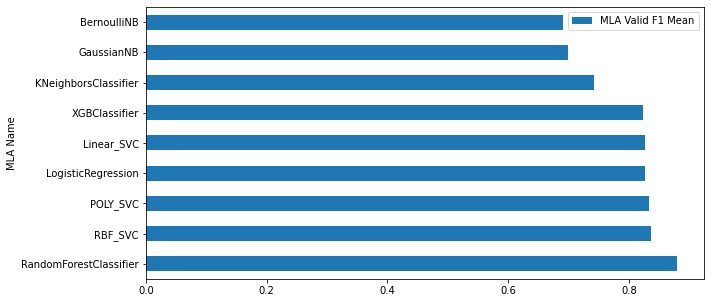

In [31]:
# Plot for keras embedding
mla_coarse_results_kr[mla_coarse_results_kr['MLA Name'] != 'MultinomialNB'].plot(kind='barh',
                                                                                 x='MLA Name',
                                                                                 y='MLA Valid F1 Mean', figsize=(10,5))

In [32]:
# Model comparison for TfIDF embedding
mla_coarse_results_tf

MLA Name   MLA Time  ...  MLA Valid Recall Mean  MLA Valid F1 Mean
8                POLY_SVC  14.230028  ...               0.913697           0.901147
0  RandomForestClassifier   7.215180  ...               0.898476           0.894007
7                 RBF_SVC  11.901810  ...               0.900082           0.891606
2              Linear_SVC   9.382304  ...               0.846416           0.832353
1      LogisticRegression   0.054061  ...               0.846417           0.832329
9           XGBClassifier   3.183725  ...               0.869041           0.823961
5           MultinomialNB   0.005553  ...               0.830997           0.816210
4             BernoulliNB   0.008682  ...               0.831196           0.801436
3    KNeighborsClassifier   0.004183  ...               0.766722           0.748342
6              GaussianNB   0.002123  ...                    NaN                NaN

[10 rows x 5 columns]

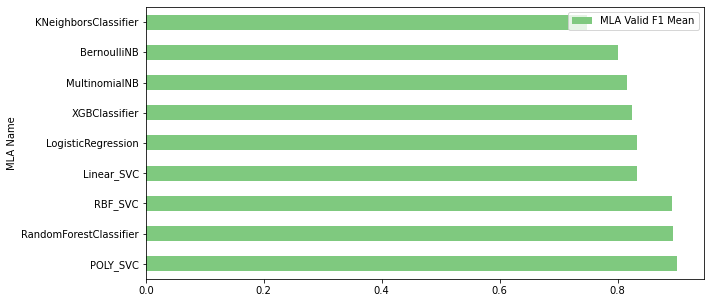

In [36]:
# Plot for keras embedding
mla_coarse_results_tf[mla_coarse_results_tf['MLA Name'] != 'GaussianNB'].plot(kind='barh',
                                                                              x='MLA Name',y='MLA Valid F1 Mean', 
                                                                              figsize=(10,5), colormap='Accent')

In [37]:
# Model comparison for TfIDF embedding
mla_coarse_results_cv

MLA Name   MLA Time  ...  MLA Valid Recall Mean  MLA Valid F1 Mean
0  RandomForestClassifier   6.909779  ...               0.891668           0.890525
7                 RBF_SVC  12.402483  ...               0.885465           0.867227
2              Linear_SVC  23.749425  ...               0.851422           0.833552
1      LogisticRegression   0.155783  ...               0.840410           0.827069
8                POLY_SVC  13.323297  ...               0.946736           0.822848
9           XGBClassifier   1.118459  ...               0.866639           0.817730
5           MultinomialNB   0.005247  ...               0.812376           0.807026
4             BernoulliNB   0.007181  ...               0.831196           0.801436
3    KNeighborsClassifier   0.004196  ...               0.762319           0.715240
6              GaussianNB   0.002100  ...                    NaN                NaN

[10 rows x 5 columns]

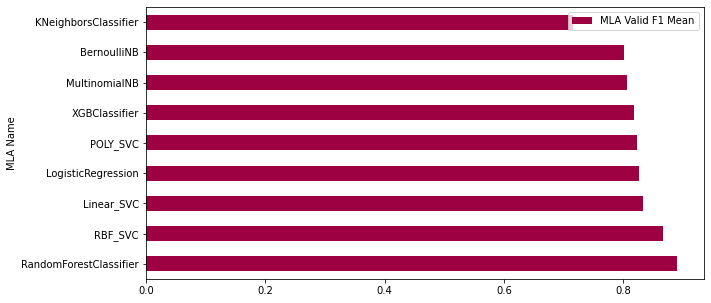

In [49]:
# Plot for keras embedding
mla_coarse_results_cv[mla_coarse_results_cv['MLA Name'] != 'GaussianNB'].plot(kind='barh',
                                                                              x='MLA Name',y='MLA Valid F1 Mean', 
                                                                              figsize=(10,5), colormap='Spectral')

## Model Intuition
- Visualize what has been learnt by the model
- Analyze how different parameter would lead to different learning place
- Can also alter preprocessing and vectorization choices, and analyze difference in performance

In [ ]:
vectorizer_tf.vocabulary_

### Linear model analysis

#### **Logistic Regression Insight**

In [13]:
def get_weight_and_features(weights, vectorizer, K=5, kind='pos'):
  # returns top / bottom k-weights and features
  idxs = list()
  reverse = False
  feature_weight = dict()

  if kind == 'pos':
    reverse = True
    idxs = np.argpartition(weights, -K)[-K:]
  else:
    idxs = np.argpartition(weights, K)[:K] 
  
  k_weights =  weights[idxs]
  k_features = [i for i, j in vectorizer.vocabulary_.items() if j in idxs]

  return {i:j for i,j in sorted(zip(k_features, k_weights), key=lambda item: item[1], reverse=reverse)}

In [14]:
# What words did Logistic give highest weight
lr_inst = linear_model.LogisticRegression()
lr_inst.fit(X_train_tf, y_train)

# Top K weighted words learnt
K = 5
print ('Positive Words with weights: ', get_weight_and_features(lr_inst.coef_[0], vectorizer_tf, K))
print ('Negative Words with weights: ', get_weight_and_features(lr_inst.coef_[0], vectorizer_tf, K, kind='neg'))

Positive Words with weights:  {'great': 5.969980805932684, 'best': 5.117927563395023, 'recommend': 4.06884421958558, 'excellent': 3.6468436437586624, 'love': 3.2938548758934783}
Negative Words with weights:  {'awful': -10.300070140270567, 'terrible': -9.132726104917086, 'bad': -8.333092256220215, 'waste': -6.277243551412124, 'worst': -6.156020887876323}


#### **Multinomial Naive Bayes Insight**

In [15]:
from sklearn.naive_bayes import MultinomialNB

mnb_inst = MultinomialNB()
mnb_inst.fit(X_train_tf, y_train)

# Top K weighted words learnt
K = 5
print ('Positive Words with weights: ', get_weight_and_features(mnb_inst.coef_[0], vectorizer_tf, K))
print ('Negative Words with weights: ', get_weight_and_features(mnb_inst.coef_[0], vectorizer_tf, K, kind='neg'))

Positive Words with weights:  {'like': -3.803419383682331, 'film': -4.0009552645771524, 'movie': -4.387275781997749, 'see': -4.4628901191813934, 'one': -4.593797365958825}
Negative Words with weights:  {'waste': -7.986807577073242, 'terrible': -7.884824814341723, 'stupid': -7.76115136447503, 'awful': -7.6826126648066815, 'worst': -7.327467112011504}


In [ ]:
from sklearn.svm import SVC 

mnb_inst = SVC(kernel='linear')
mnb_inst.fit(X_train_tf, y_train)

# Top K weighted words learnt
K = 5
print ('Positive Words with weights: ', get_weight_and_features(mnb_inst.coef_[0], vectorizer_tf, K))
print ('Negative Words with weights: ', get_weight_and_features(mnb_inst.coef_[0], vectorizer_tf, K, kind='neg'))

#### **Data in 2D**

In [ ]:
import matplotlib
X_train_tsne, X_test_tsne, vectorizer_tsne_tf = vectorizer(imdb_train['P_text'], imdb_test['P_text'], model='tf-idf', n_dims=300)

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_train_2d_tsne = tsne.fit_transform(X_train_tsne)

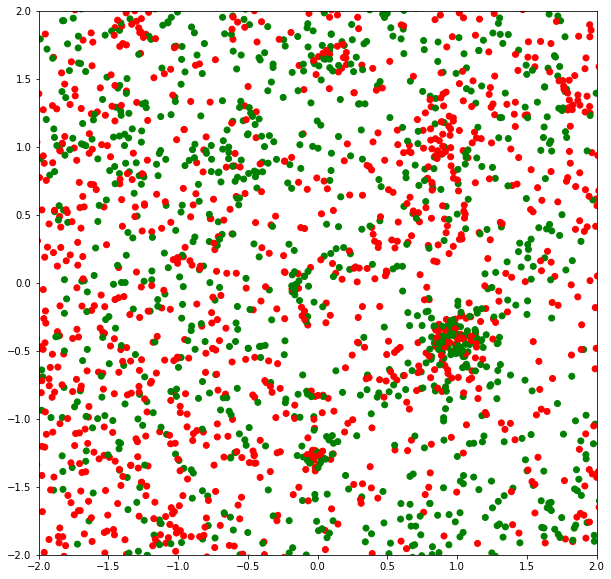

In [ ]:
colors = ['red','green']
fig = plt.figure(figsize=(10,10))
plt.ylim((-2, 2))
plt.xlim((-2, 2))
plt.scatter(X_train_2d_tsne[:,0], X_train_2d_tsne[:,1], c=y_train, cmap=matplotlib.colors.ListedColormap(colors))

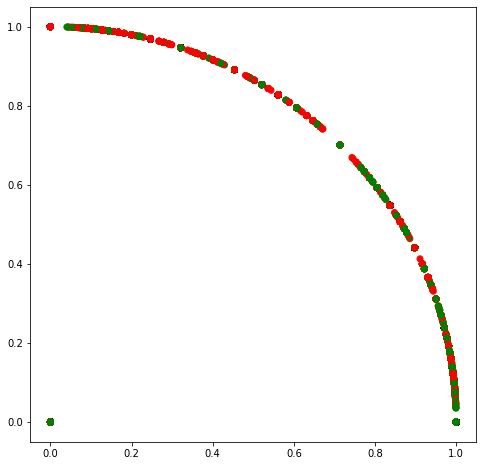

In [ ]:
import matplotlib
X_train_2d, X_test_2d, vectorizer_2d_tf = vectorizer(imdb_train['P_text'], imdb_test['P_text'], model='tf-idf', n_dims=2)

colors = ['red','green']
fig = plt.figure(figsize=(8,8))
plt.scatter(X_train_2d[:,0].toarray(), X_train_2d[:,1].toarray(), c=y_train, cmap=matplotlib.colors.ListedColormap(colors))

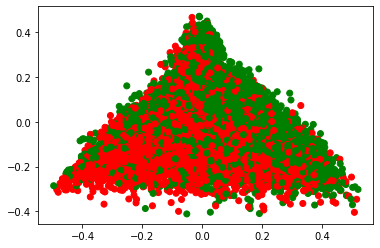

In [ ]:
# PCA analysis
from sklearn.decomposition import PCA
pca_inst = PCA(n_components=2)
X_train_2d_pca = pca_inst.fit_transform(X_train_tf.toarray())

plt.scatter(X_train_2d_pca[:,0], X_train_2d_pca[:,1], c=y_train, cmap=matplotlib.colors.ListedColormap(colors))

#### **Data in 3D**

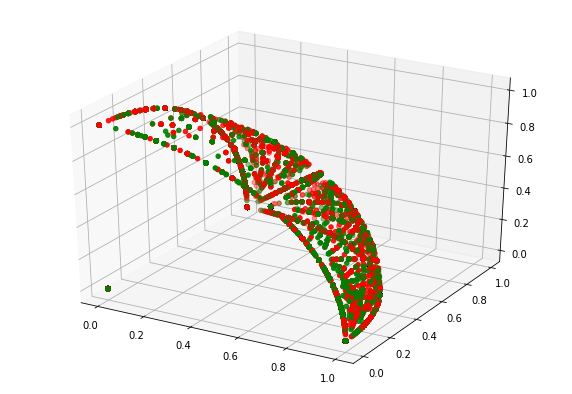

In [ ]:
X_train_3d, X_test_3d, vectorizer_3d_tf = vectorizer(imdb_train['P_text'], imdb_test['P_text'], model='tf-idf', n_dims=3)
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(X_train_3d[:,0].toarray(), X_train_3d[:,1].toarray(), X_train_3d[:,2].toarray(), c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
 
# show plot
plt.show()

#### **SVC analysis for 2D data**

In [ ]:
def plot_svc(X, y):
  # we create an instance of SVM and fit out data. We do not scale our
  # data since we want to plot the support vectors
  C = 1.0  # SVM regularization parameter
  h = .02
  svc = svm.SVC(kernel='linear', C=C).fit(X, y)
  rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
  poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
  lin_svc = svm.LinearSVC(C=C).fit(X, y)

  # create a mesh to plot in
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                      np.arange(y_min, y_max, h))

  # title for the plots
  titles = ['SVC with linear kernel',
            'LinearSVC (linear kernel)',
            'SVC with RBF kernel',
            'SVC with polynomial (degree 3) kernel']


  for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
      # Plot the decision boundary. For that, we will assign a color to each
      # point in the mesh [x_min, x_max]x[y_min, y_max].
      plt.subplot(2, 2, i + 1)
      plt.subplots_adjust(wspace=0.4, hspace=0.4)

      Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

      # Put the result into a color plot
      Z = Z.reshape(xx.shape)
      plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

      # Plot also the training points
      plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
      plt.xlabel('Sepal length')
      plt.ylabel('Sepal width')
      plt.xlim(xx.min(), xx.max())
      plt.ylim(yy.min(), yy.max())
      plt.xticks(())
      plt.yticks(())
      plt.title(titles[i])

  plt.show()

In [ ]:
plot_svc(X_train_2d_pca, y_train)

NameError: ignored

### Bayesian models analysis

### Tree / Ensemble models analysis

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Analyzing performance before analysis
rf_inst = RandomForestClassifier(max_depth=5)
rf_inst.fit(X_train_tf, y_train)

print (classification_report(y_train, rf_inst.predict(X_train_tf)))

              precision    recall  f1-score   support

           0       0.84      0.69      0.76     22505
           1       0.74      0.87      0.80     22495

    accuracy                           0.78     45000
   macro avg       0.79      0.78      0.78     45000
weighted avg       0.79      0.78      0.78     45000



In [ ]:
# Visualizing one of the decision trees
from sklearn.tree import export_graphviz

# Export as dot file
export_graphviz(rf_inst.estimators_[5], 
                out_file='tree.dot', 
                feature_names = list(vectorizer_tf.vocabulary_.keys()),
                class_names = ['0', '1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [ ]:
# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=1000'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png', height = 400)

### KNN + Unsupervised K-Means analysis

## Model Evaluation (Test set)